In [9]:
from deepxde.nn.pytorch.deeponet import DeepONet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

# 1. device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. define PI‑DeepONet operator (outputs [q, p])
r = 64
operator_net = DeepONet(
    layer_sizes_branch=[4, 256, 256, 128, r],   # inputs: q0, p0, m, k
    layer_sizes_trunk=[1, 256, 256, 128, r],    # input: time t
    activation="sin",
    kernel_initializer=torch.nn.init.xavier_uniform_,
    num_outputs=2
).to(device)

# 3. define H‑net (outputs scalar Hamiltonian)
H_net = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
).to(device)

# 4. weight initialization
def init_fn(module):
    if isinstance(module, nn.Linear):
        nn.init.xavier_uniform_(module.weight)
        module.bias.data.fill_(0.0)

operator_net.apply(init_fn)
H_net.apply(init_fn)

# 5. optimizer (joint train)
optimizer = optim.LBFGS(
    list(operator_net.parameters()) + list(H_net.parameters()),
    line_search_fn="strong_wolfe"
)

loss_track = []


# 6. sampler for (q0, p0, m, k, t)
def sample_batch(batch_size, q0_range, p0_range, m_range, k_range, t_range):
    q0 = torch.empty(batch_size,1).uniform_(*q0_range)
    p0 = torch.empty(batch_size,1).uniform_(*p0_range)
    m  = torch.empty(batch_size,1).uniform_(*m_range)
    k  = torch.empty(batch_size,1).uniform_(*k_range)
    t  = torch.empty(batch_size,1).uniform_(*t_range)
    for x in (q0, p0, m, k, t):
        x.to(device)
    t.requires_grad_(True)
    return q0, p0, m, k, t

# 7. training closure
def closure():
    optimizer.zero_grad()

    # sample collocation batch
    q0_b, p0_b, m_b, k_b, t_b = sample_batch(
        batch_size=4096,
        q0_range=(-4,4),
        p0_range=(-4,4),
        m_range=(2.0,2.0),
        k_range=(1.0,1.0),
        t_range=(0.0, 10.0),
    )

    # branch & trunk inputs
    branch_in = torch.cat((q0_b, p0_b, m_b, k_b), dim=1)  # [B,4]
    trunk_in  = t_b                                       # [B,1]

    # 7.1 predict u(t) = [q, p]
    u = operator_net((branch_in, trunk_in))              # [B,2]
    q_pred = u[:, 0:1]
    p_pred = u[:, 1:2]

    # 7.2 time derivatives via auto‑diff
    ones = torch.ones_like(q_pred)
    dqdt = torch.autograd.grad(q_pred, t_b, grad_outputs=ones,
                                create_graph=True)[0]
    dpdt = torch.autograd.grad(p_pred, t_b, grad_outputs=ones,
                                create_graph=True)[0]

    # 7.3 SHO residual loss
    r_q = dqdt - p_pred / m_b
    r_p = dpdt + k_b * q_pred
    loss_sho = torch.mean(r_q**2 + r_p**2)

    # 7.4 Hamiltonian flow residual
    u.requires_grad_(True)
    H_pred = H_net(u)                                    # [B,1]
    ones_H = torch.ones_like(H_pred)
    dH_du = torch.autograd.grad(H_pred, u, grad_outputs=ones_H,
                                create_graph=True)[0]     # [B,2]
    dH_dq = dH_du[:, 0:1]
    dH_dp = dH_du[:, 1:2]
    fH_q =  dH_dp
    fH_p = -dH_dq
    r_flow_q = dqdt - fH_q
    r_flow_p = dpdt - fH_p
    loss_flow = torch.mean(r_flow_q**2 + r_flow_p**2)

    # 7.5 initial‑condition loss: enforce u(0) = (q0, p0)
    t0_b = torch.zeros_like(t_b)
    u0 = operator_net((branch_in, t0_b))
    q0_pred = u0[:, 0:1]
    p0_pred = u0[:, 1:2]
    loss_ic = torch.mean((q0_pred - q0_b)**2 + (p0_pred - p0_b)**2)

    # 7.6 supervised Hamiltonian loss
    H_true = p_pred**2 / (2*m_b) + 0.5 * k_b * q_pred**2
    loss_hsup = torch.mean((H_pred - H_true)**2)

    # 7.7 total loss
    loss = loss_sho + loss_flow + loss_ic + loss_hsup
    
    if torch.isnan(loss) or torch.isinf(loss):
        print("Loss is NaN or Inf, skipping backward pass.")
        return torch.tensor(loss_track[-1]) if loss_track else 0.0
    
    loss.backward()
    return loss

# 8. run training
progress_bar = tqdm(range(1000))
for _ in progress_bar:
    optimizer.step(closure)
    loss_track.append(closure().item())
    progress_bar.set_postfix(Loss=loss_track[-1])

# 9. save models
torch.save(operator_net.state_dict(), "deep_onet_operator.pth")
torch.save(H_net.state_dict(),         "h_net.pth")


100%|██████████| 1000/1000 [04:19<00:00,  3.85it/s, Loss=0.0115]


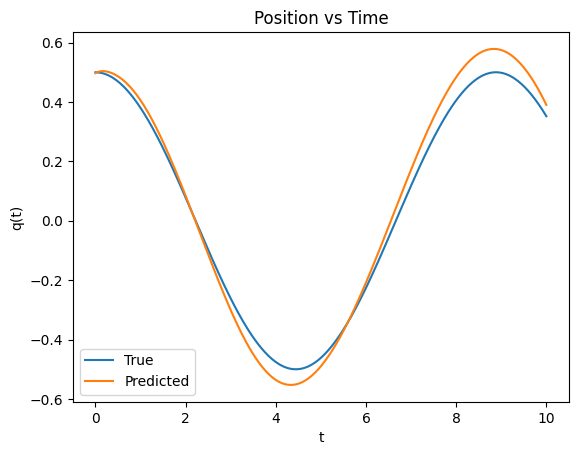

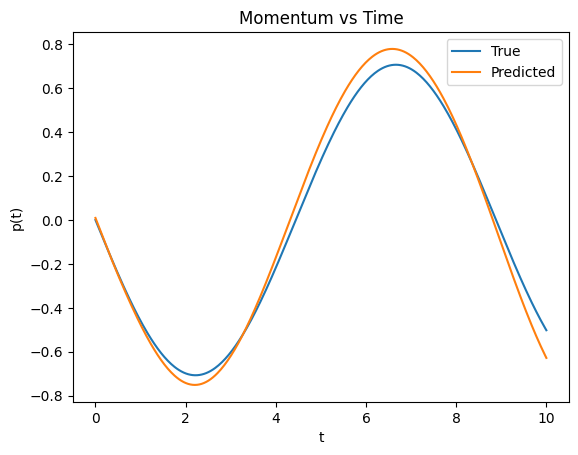

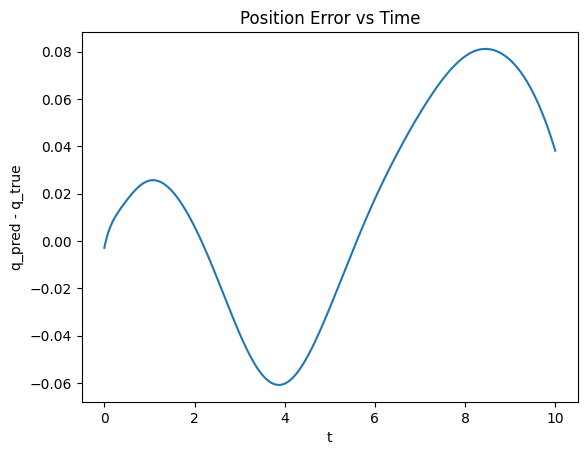

In [11]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# re-create the trained networks
r = 64
operator_net = DeepONet(
    layer_sizes_branch=[4, 256, 256, 128, r],
    layer_sizes_trunk=[1, 256, 256, 128, r],
    activation="sin",
    kernel_initializer=nn.init.xavier_uniform_,
    num_outputs=2
).to(device)

H_net = nn.Sequential(
    nn.Linear(2, 64),
    nn.Tanh(),
    nn.Linear(64, 64),
    nn.Tanh(),
    nn.Linear(64, 1),
).to(device)

# load saved weights
operator_net.load_state_dict(torch.load("deep_onet_operator.pth", map_location=device))
H_net.load_state_dict(torch.load("h_net.pth", map_location=device))
operator_net.eval()
H_net.eval()

# initial conditions and parameters
q0, p0 = 0.5, 0.0
m, k = 2.0, 1.0

# time grid for evaluation
t_span = (0.0, 10.0)
t_eval = np.linspace(t_span[0], t_span[1], 400)

# true solution via SciPy
def sho_ode(t, y):
    return [y[1]/m, -k*y[0]]

sol = solve_ivp(sho_ode, t_span, [q0, p0], t_eval=t_eval)
q_true, p_true = sol.y

# operator-net predictions
t_tensor = torch.tensor(t_eval.reshape(-1,1), dtype=torch.float32, device=device)
branch = torch.tensor([[q0, p0, m, k]], dtype=torch.float32, device=device).repeat(len(t_eval),1)

with torch.no_grad():
    u_pred = operator_net((branch, t_tensor))
q_pred = u_pred[:, 0].cpu().numpy()
p_pred = u_pred[:, 1].cpu().numpy()

# plot position
plt.figure()
plt.plot(t_eval, q_true, label="True")
plt.plot(t_eval, q_pred, label="Predicted")
plt.xlabel("t")
plt.ylabel("q(t)")
plt.legend()
plt.title("Position vs Time")
plt.show()

# plot momentum
plt.figure()
plt.plot(t_eval, p_true, label="True")
plt.plot(t_eval, p_pred, label="Predicted")
plt.xlabel("t")
plt.ylabel("p(t)")
plt.legend()
plt.title("Momentum vs Time")
plt.show()

# plot position error
plt.figure()
plt.plot(t_eval, q_pred - q_true)
plt.xlabel("t")
plt.ylabel("q_pred - q_true")
plt.title("Position Error vs Time")
plt.show()
